#  Evolutionary Multiple-objective Optimization (part for 4.0)

- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA/NSGA-II/NSGA-II/MOEA/D/IBEA/HypE/SPEA2). It is recommended to implement NSGA-II or MOEA/D. 
- Note that it has to be your implementation (using external libraries is forbidden).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, consider also the three-objective one. As for the third objective, think about some reasonable risk-measure. You can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc. 

In [3]:
from utils import *

dataPath = "./data/Bundle2"
stock_data = readData(dataPath)
stock_data, confidences = getPredictions(stock_data)

## Comparison of previous predictions to actual data

In [4]:
prev_dataPath = "./data/Bundle1"

prev_stock_data = readData(prev_dataPath)
prev_stock_data, _ = getPredictions(prev_stock_data)

matched_stock_data = []
for prev_company in prev_stock_data:
    for company in stock_data:
        if prev_company.name == company.name:
            matched_stock_data.append((prev_company, company))
            break

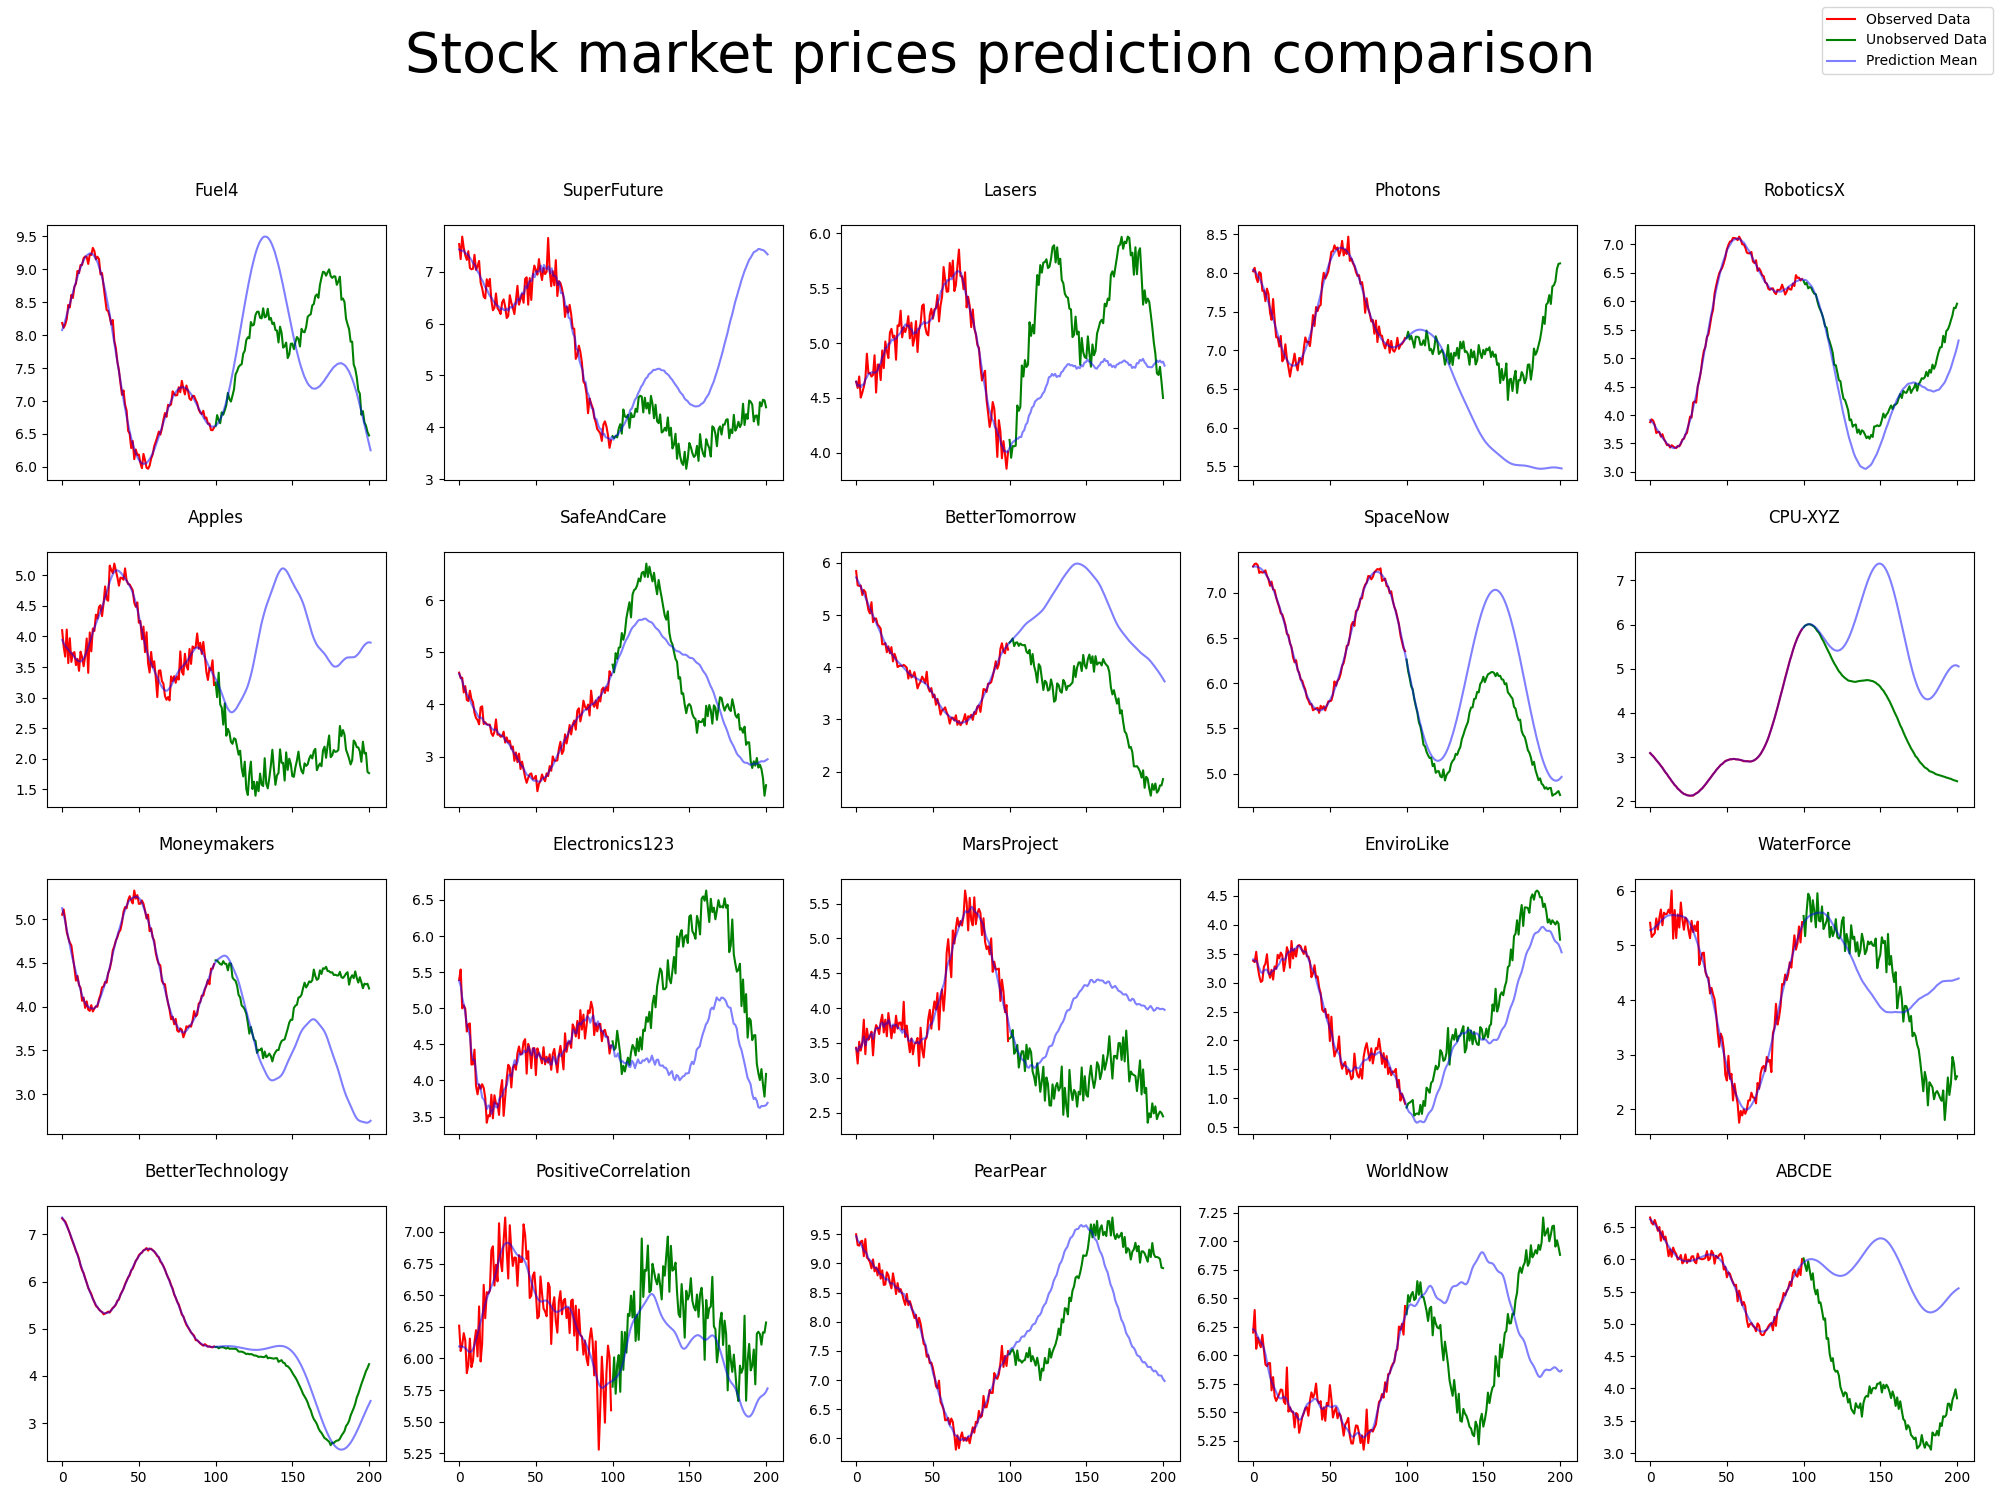

In [5]:
import matplotlib.pyplot as plt
%matplotlib widget

fig, axes = plt.subplots(4, 5, figsize=(20, 15), sharex=True)
fig.tight_layout(h_pad=5)
plt.subplots_adjust(top=0.85)
for company_idx, (prev_company, company) in enumerate(matched_stock_data):
    row = company_idx // 5
    col = company_idx - row * 5
    x = company.datax
    y = company.datay
    axes[row, col].set_title(company.name)
    axes[row, col].plot(x[:100], y[:100], 'r-')
    axes[row, col].plot(x[100:], y[100:], 'g-')
    axes[row, col].plot(prev_company.pred_datax, prev_company.pred_datay, 'b', alpha=0.5)
fig.suptitle("Stock market prices prediction comparison", fontsize = 40)
fig.legend(['Observed Data', 'Unobserved Data', 'Prediction Mean'], loc='upper right')
plt.savefig('./plots/prediction_comparison_1-2.svg')
plt.show()

## New predictions

In [6]:
from copy import deepcopy

# Calculate Confidence objective with normalization
confidences_f = np.array([i[-1][-1] for i in list(confidences.values())])
min_confidence = np.min(confidences_f)
max_confidence = np.max(confidences_f)
# Minimise region <=> Maximize confidence 
for i in range(len(stock_data)):
    stock_data[i].new_risk_factor = (confidences_f[i] - min_confidence) / (max_confidence - min_confidence)

# Normalize Return
ret = [i.increase for i in stock_data]
max_return = max(ret)
min_return = min(ret)
delta_return = max_return - min_return
stock_data_norm = deepcopy(stock_data)
# with conversion to Minimization
for i in range(len(stock_data)):
    stock_data_norm[i].increase = (delta_return - (stock_data[i].increase - min_return)) / delta_return

# Normalize Risk
risk_matrix = getRiskMatrix(stock_data)
risk_matrix_norm = deepcopy(risk_matrix)
risk_matrix_norm = ((risk_matrix_norm - np.min(risk_matrix_norm)) / (np.max(risk_matrix_norm) - np.min(risk_matrix_norm))) / len(stock_data)
row_sums = risk_matrix_norm.sum(axis=1)
risk_matrix_norm = ((risk_matrix_norm - np.min(row_sums) / len(stock_data)) / (np.max(row_sums) -  np.min(row_sums)))

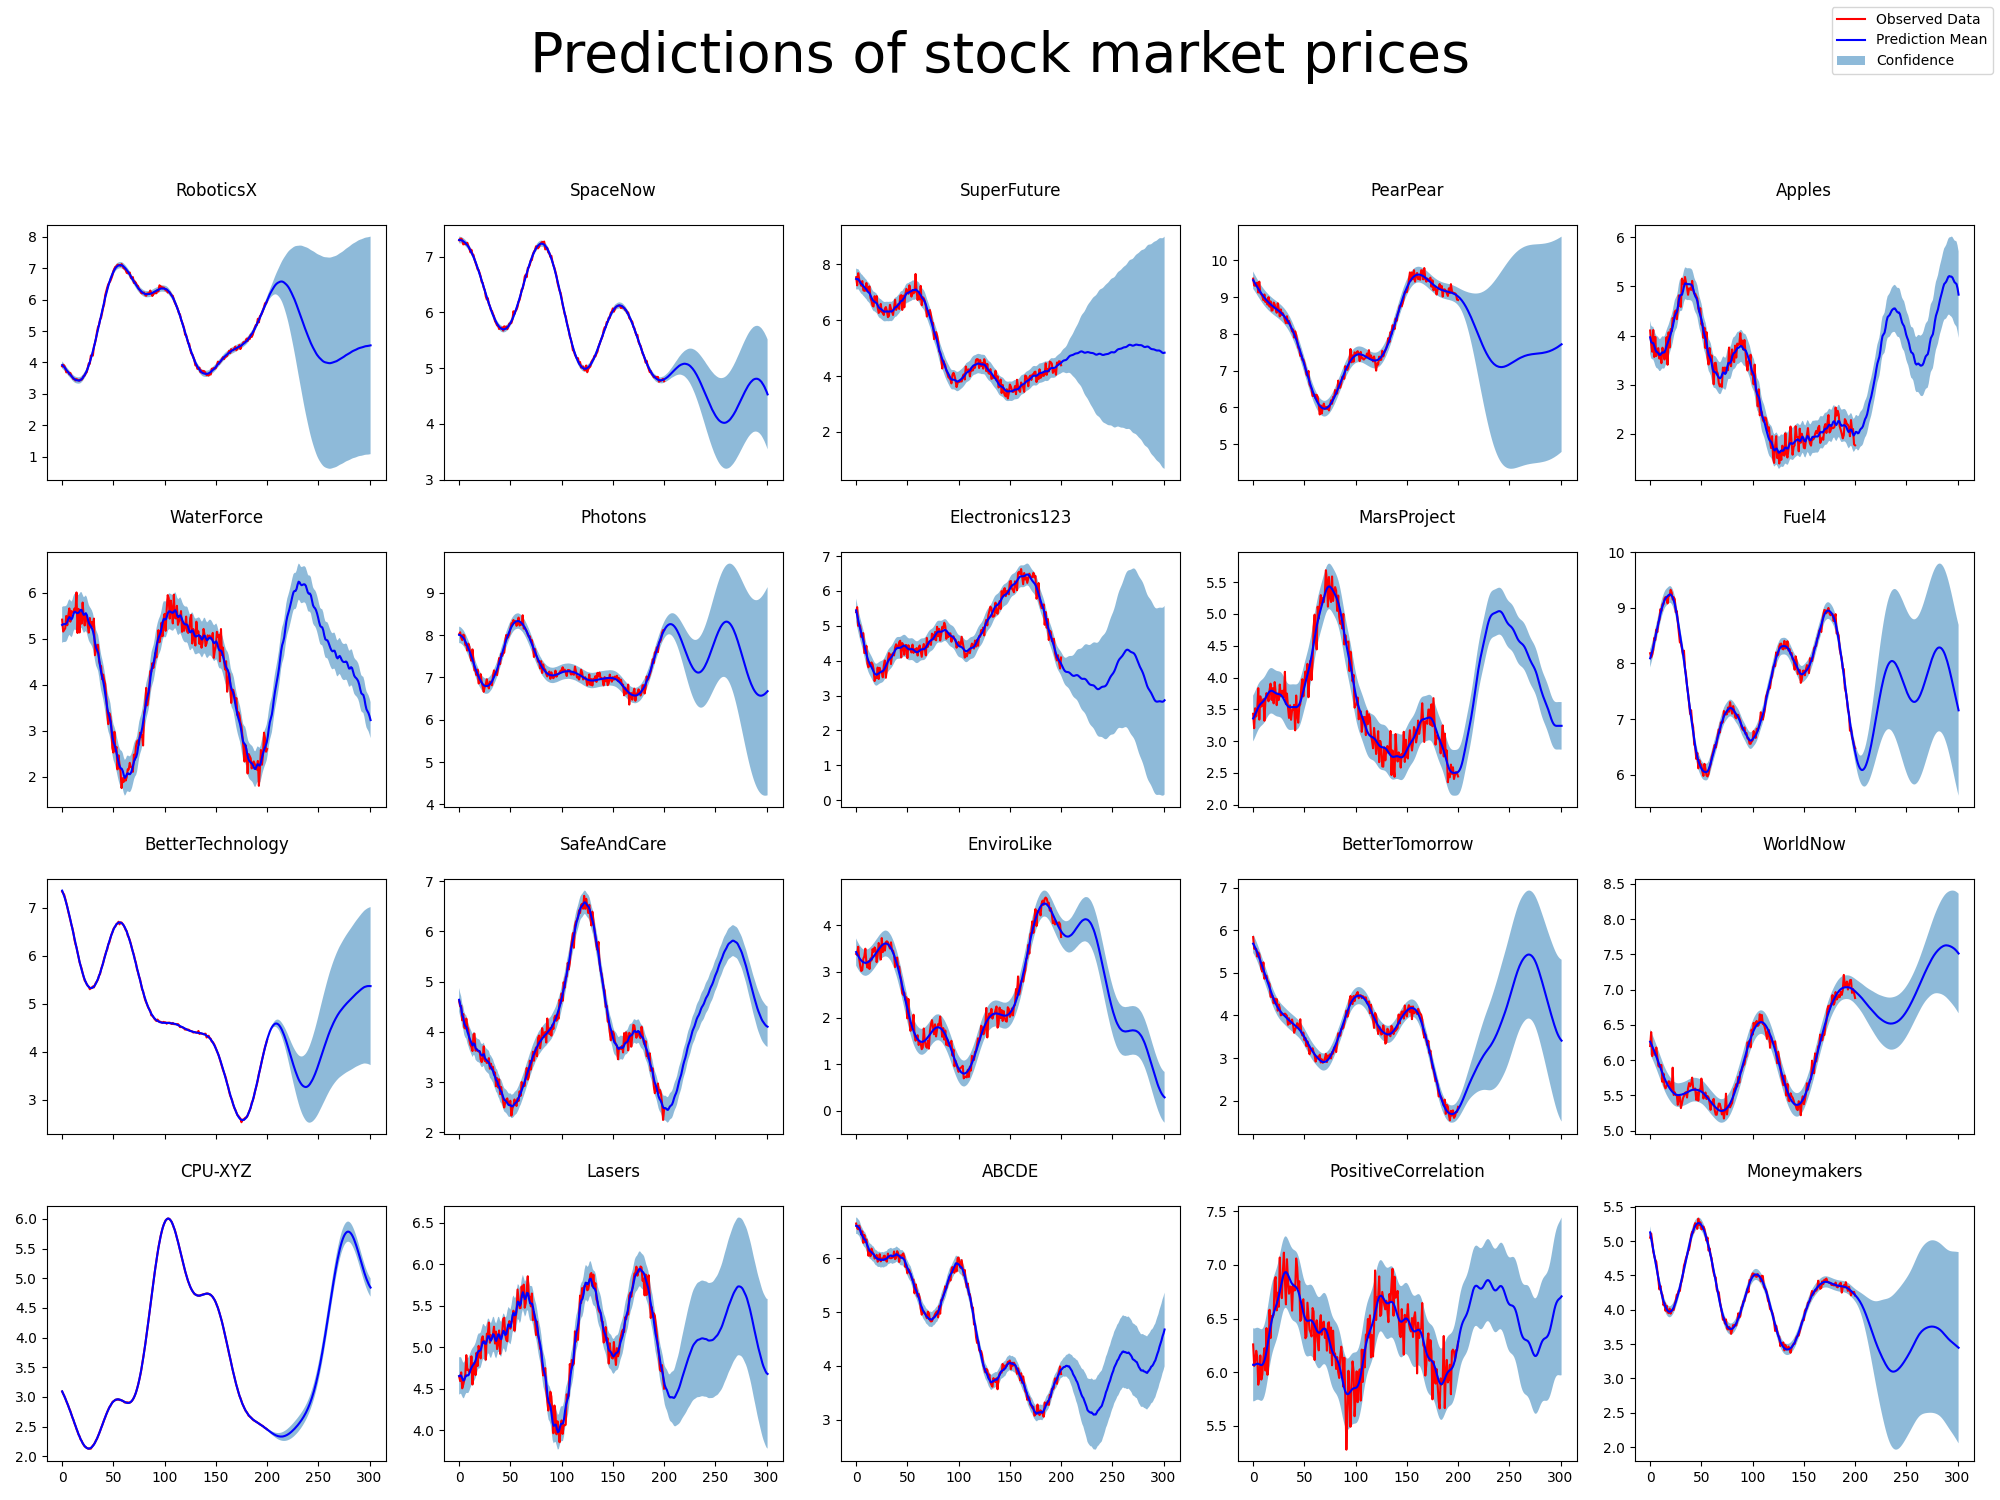

In [7]:
fig, axes = plt.subplots(4, 5, figsize=(20, 15), sharex=True)
fig.tight_layout(h_pad=5)
plt.subplots_adjust(top=0.85)
for company_idx, company in enumerate(stock_data):
    row = company_idx // 5
    col = company_idx - row * 5
    x = company.datax
    y = company.datay
    axes[row, col].set_title(company.name)
    axes[row, col].plot(x, y, 'r-')
    axes[row, col].plot(company.pred_datax, company.pred_datay, 'b')
    axes[row, col].fill_between(company.pred_datax, confidences[company.name][0], confidences[company.name][1], alpha=0.5)
fig.suptitle("Predictions of stock market prices", fontsize = 40)
fig.legend(['Observed Data', 'Prediction Mean', 'Confidence'], loc='upper right')
plt.savefig('./plots/predictions2.svg')
plt.show()

## MOEA/D

In [8]:
import math
from tqdm import tqdm

class Line:
    def __init__(self, a, b) -> None:
        self.a = a
        self.b = b
    def __hash__(self) -> int:
        return int(1000 * self.a + 1_000_000 * self.b)

### 3D case

In [17]:
class MOEAD_3D():
    def __init__(self, 
                 stock_data,
                 risk_matrix, 
                 population_size, 
                 num_iterations, 
                 num_objectives, 
                 num_neighbors, 
                 crossover_rate, 
                 mutation_rate):
        self.stock_data = stock_data
        self.risk_matrix = risk_matrix

        self.solution_size = len(stock_data)
        self.population_size = population_size
        self.num_iterations = num_iterations
        self.num_objectives = num_objectives
        self.num_neighbors = num_neighbors
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate


    def initialize_population(self):
        def generate_random_solution():
            solution = np.random.uniform(size = self.solution_size)
            solution /= solution.sum()
            return solution

        population = {}
        for i in range(self.population_size):
            population[i] = generate_random_solution()
        return population

    # Return, Risk, Confidence
    def calc_point(self, solution_weights) :
        return (
            sum([float(self.stock_data[j].increase) * solution_weights[j] for j in range(self.solution_size)]),
            sum([sum(self.risk_matrix[j]) * solution_weights[j] for j in range(self.solution_size)]),
            sum([float(self.stock_data[j].new_risk_factor) * solution_weights[j] for j in range(self.solution_size)])
        )

    def calc_population_points(self):
        points = {}
        for i in self.population.keys():
            points[i] = self.calc_point(self.population[i])
        return points


    def create_objectives_lines(self):
        obj_lines = {}
        for deg in np.linspace(0, 89, self.num_objectives):
            for deg2 in np.linspace(0, 89, self.num_objectives):
                # point, distance, value
                obj_lines[Line(math.tan(np.deg2rad(deg)), math.tan(np.deg2rad(deg2)))] = []
        return obj_lines


    # Check distance to objective lines and assign solutions
    def update_population(self):
        def distance_point_line(a, point):
            def magnitude(vec):
                return (vec[0]*vec[0] + vec[1]*vec[1] + vec[2]*vec[2])**0.5

            line = np.array([1, a.a, a.b])
            v = line - np.array([point[0], point[1], point[2]])
            proj = ((v*line) / (magnitude(line)**2)) * line
            d = v - proj
            return magnitude(d)
        def w_chebyshev(point):
            return max(point)

        for point in list(self.population_points.keys()):
            point_coord = self.population_points[point]
            best_line = list(self.a_objective_lines.keys())[0]
            best_distance = distance_point_line(best_line, point_coord)
            for objective_l in list(self.a_objective_lines.keys())[1:]:
                temp_d = distance_point_line(objective_l, point_coord)
                if best_distance > temp_d:
                    best_line = objective_l
                    best_distance = temp_d
            self.a_objective_lines[best_line].append([point, w_chebyshev(self.population_points[point])])
        for a in self.a_objective_lines.keys():
            temp = self.a_objective_lines[a]
            if len(temp) > 1:
                temp = sorted(temp, key=lambda x:x[1])
                self.a_objective_lines[a] = [temp[0]]

        def clean_dominated():
            current = []
            for i in self.a_objective_lines.values():
                try:
                    current.append(i[0][0])
                except Exception:
                    pass
            for k in list(set(self.population_points.keys()) - set(current)):
                self.old_points.append(self.population_points[k])
                del self.population_points[k]
                del self.population[k]

        clean_dominated()

    def get_kNN(self, i, k):
        def points_distance(p1, p2):
            return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2) ** 0.5

        stack=[[key,
                points_distance(self.population_points[key],
                                self.population_points[i])] for key in self.population_points.keys()]
        return list(np.array(sorted(stack, key = lambda x: x[1]))[:k,0])

    def crossover(self, population_idx):
        crossover_product = np.random.randint(0, len(population_idx), len(self.stock_data))
        return [self.population[population_idx[i]][pos] for pos, i in enumerate(crossover_product)]

    def mutate(self,offspring):
        offspring += np.random.binomial(1, self.mutation_rate, len(offspring)) * np.random.random(len(offspring))
        offspring /= offspring.sum()
        return offspring


    def solve(self):
        # {index: solution}
        self.population = self.initialize_population()
        # {index: point(x, y, z)}
        self.population_points = self.calc_population_points()
        self.a_objective_lines = self.create_objectives_lines()

        self.old_points = []
        self.update_population()

        for iteration in tqdm(range(self.num_iterations)):
            solution_idx = list(self.population.keys())
            for i in solution_idx:
                neighbours = self.get_kNN(i, k = self.num_neighbors)
                offspring = self.crossover(neighbours)
                offspring = self.mutate(offspring)
                neighbours.append(int(max(list(self.population.keys())) + 1))
                self.population[neighbours[-1]] = offspring
                self.population_points[neighbours[-1]] = self.calc_point(offspring)
            self.update_population()
        return list(self.population.values()),self.population_points

    def plot_state(self):
        ax = plt.figure().add_subplot(projection = '3d')
        points = np.array(list(self.population_points.values()))
        ax.scatter(points[:,0], points[:,1], points[:,2], c="#ff0000")
        ax.set_xlabel('Return')
        ax.set_ylabel('Risk')
        ax.set_zlabel('Confidence')
        plt.show()

100%|██████████| 1000/1000 [11:43<00:00,  1.42it/s]


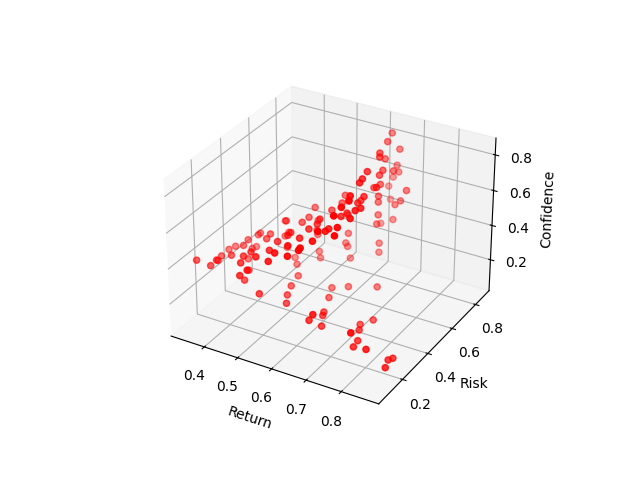

In [18]:
population_size = 300
num_iterations = 1000
num_objectives = 30
num_neighbors = 1
crossover_rate = 0.9
mutation_rate = 0.1

solver = MOEAD_3D(stock_data_norm,
                  risk_matrix_norm,
                  population_size,
                  num_iterations,
                  num_objectives,
                  num_neighbors,
                  crossover_rate,
                  mutation_rate)

final_population = solver.solve()
solver.plot_state()

### 2D case

In [12]:
class MOEAD_2D(MOEAD_3D):
    def __init__(self, 
                 stock_data,
                 risk_matrix, 
                 population_size, 
                 num_iterations, 
                 num_objectives, 
                 num_neighbors, 
                 crossover_rate, 
                 mutation_rate):
        super().__init__(stock_data,
                         risk_matrix,
                         population_size,
                         num_iterations,
                         num_objectives,
                         num_neighbors,
                         crossover_rate,
                         mutation_rate)

    # Return, Risk
    def calc_point(self, solution_weights) :
        return (
            sum([float(self.stock_data[j].increase) * solution_weights[j] for j in range(self.solution_size)]),
            sum([sum(self.risk_matrix[j]) * solution_weights[j] for j in range(self.solution_size)]),
        )

    def create_objectives_lines(self):
        obj_lines = {}
        for deg in np.linspace(0, 89, self.num_objectives):
                # point, distance, value
                obj_lines[math.tan(np.deg2rad(deg))] = []
        return obj_lines


    # Check distance to objective lines and assign solutions
    def update_population(self):
        def distance_point_line(a, point):
            return abs(a*point[0]-point[1])/(a*a+1)**0.5
        def w_chebyshev(point):
            return max(point)

        for point in list(self.population_points.keys()):
            point_coord = self.population_points[point]
            best_line = list(self.a_objective_lines.keys())[0]
            best_distance = distance_point_line(best_line, point_coord)
            for objective_l in list(self.a_objective_lines.keys())[1:]:
                temp_d = distance_point_line(objective_l, point_coord)
                if best_distance > temp_d:
                    best_line = objective_l
                    best_distance = temp_d
            self.a_objective_lines[best_line].append([point, w_chebyshev(self.population_points[point])])
        for a in self.a_objective_lines.keys():
            temp = self.a_objective_lines[a]
            if len(temp) > 1:
                temp = sorted(temp, key=lambda x:x[1])
                self.a_objective_lines[a] = [temp[0]]

        def clean_dominated():
            current = []
            for i in self.a_objective_lines.values():
                try:
                    current.append(i[0][0])
                except Exception:
                    pass
            for k in list(set(self.population_points.keys()) - set(current)):
                self.old_points.append(self.population_points[k])
                del self.population_points[k]
                del self.population[k]

        clean_dominated()


    def get_kNN(self, i, k):
        def points_distance(p1, p2):
            return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 ) ** 0.5

        stack=[[key,
                points_distance(self.population_points[key],
                                self.population_points[i])] for key in self.population_points.keys()]
        return list(np.array(sorted(stack, key = lambda x: x[1]))[:k,0])

    def plot_state(self):
        ax = plt.figure().add_subplot()
        points = np.array(list(self.population_points.values()))
        ax.plot(points[:,0], points[:,1], '.r')
        ax.set_xlabel('Return')
        ax.set_ylabel('Risk')
        plt.show()

100%|██████████| 1000/1000 [00:01<00:00, 524.80it/s]


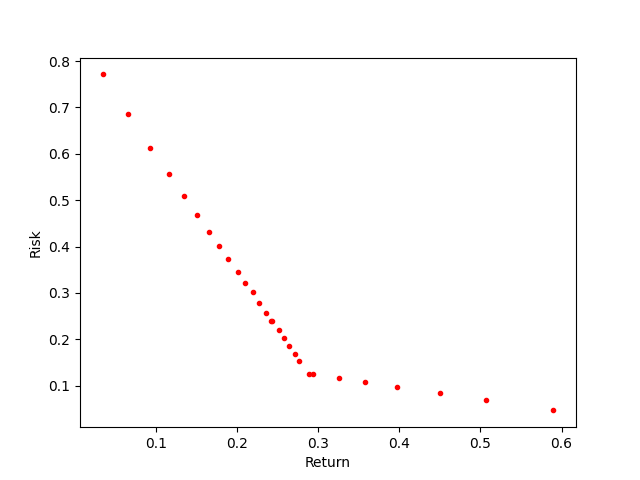

In [14]:
population_size = 300
num_iterations = 1000
num_objectives = 30
num_neighbors = 1
crossover_rate = 0.9
mutation_rate = 0.1

solver2d = MOEAD_2D(stock_data_norm,
                  risk_matrix_norm, 
                  population_size, 
                  num_iterations, 
                  num_objectives, 
                  num_neighbors, 
                  crossover_rate, 
                  mutation_rate)

final_population_2d = solver2d.solve()
solver2d.plot_state()

#### Portfolio game

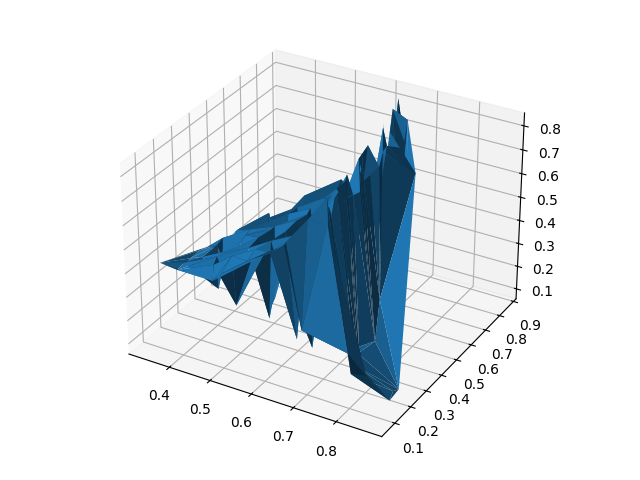

In [36]:
choosed = np.array(list(final_population[1].values()))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(choosed[:,0],choosed[:,1],choosed[:,2])
fig.tight_layout()
plt.show()
choosed = sorted(list(final_population[1].values()),key=lambda x: x[1])[12]

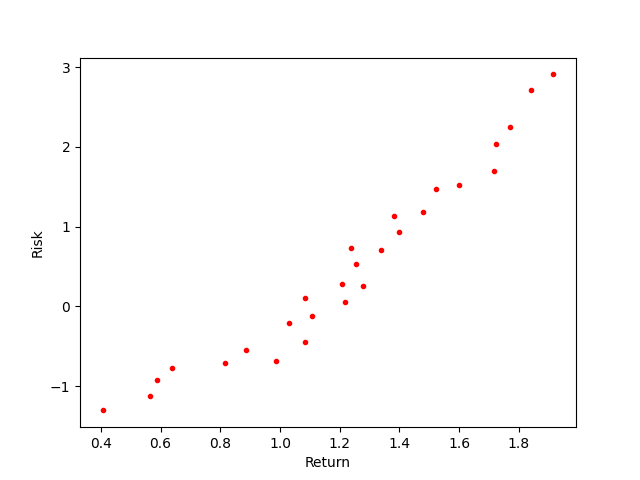

In [ ]:
x, y = [], []
for weights_solution in final_population:
    x.append(sum([float(stock_data[i].increase) * weights_solution[i] for i in range(len(stock_data))]))
    y.append(sum([sum(risk_matrix[i]) * weights_solution[i] for i in range(len(stock_data))]))

fig, ax = plt.subplots(1, 1)
ax.plot(x, y, '.r', zorder=0)
ax.set_xlabel('Return')
ax.set_ylabel('Risk')
plt.show()

#### Experimental evaluation

##### Get ECM results for further comparison

In [ ]:
from cvxopt import matrix, solvers

def WSM(weights, norm_return = 1.0, norm_risk = 1.0):
    Q = 2.0 / norm_risk * matrix([[weights[0] * risk_matrix[i][j] for i in range(len(stock_data))] for j in range(len(stock_data))])
    c = matrix([-weights[1] * float(i.increase) / norm_return for i in stock_data])
    G = matrix([[0.0 if j != i else -1.0 for j in range(len(stock_data))] for i in range(len(stock_data))])
    h = matrix([0.0 for i in stock_data])
    A = matrix([1.0 for j in range(len(stock_data))], (1, len(stock_data)))
    b = matrix(1.0)
    return solvers.qp(Q, c, G, h, A, b)

def ECM(epsilon):
    Q = 2.0 * matrix([[risk_matrix[i][j] for i in range(len(stock_data))] for j in range(len(stock_data))])
    c = matrix([0.0 for _ in stock_data])
    G = matrix([[0.0 if j != i else -1.0 for j in range(len(stock_data))] + [-stock_data[i].increase] for i in range(len(stock_data))])
    h = matrix([0.0 for i in stock_data] + [-epsilon])
    A = matrix([1.0 for j in range(len(stock_data))], (1, len(stock_data)))
    b = matrix(1.0)
    return solvers.qp(Q, c, G, h, A, b)

In [ ]:
result=[]

weights = [0.0, 1.0]
solLP = WSM(weights)

weights = list(solLP['x'])
result_return = [
    sum([float(stock_data[i].increase) * weights[i] for i in range(len(stock_data))]),
    sum([sum(risk_matrix[i]) * weights[i] for i in range(len(stock_data))]),
]
max_return = result_return[0]

threshold = 1000
for epsilon in np.linspace(0.0, max_return, threshold):
    try:
        solLP = ECM(epsilon)
        f = list(solLP['x'])
        coordinates = [
            sum([float(stock_data[i].increase) * f[i] for i in range(len(stock_data))]),
            sum([sum(risk_matrix[i]) * f[i] for i in range(len(stock_data))]),
        ]
        result.append(coordinates)
    except:
        pass
x=[]
y=[]
for i in result:
    x.append(i[0])
    y.append(i[1])
pareto_front_ecm = (x, y)

     pcost       dcost       gap    pres   dres
 0: -8.6032e+00 -3.2465e+00  1e+02  8e+00  5e+00
 1: -7.8694e-01 -3.1211e+00  2e+00  8e-15  9e-16
 2: -1.8880e+00 -2.2553e+00  4e-01  5e-16  6e-16
 3: -2.2414e+00 -2.2472e+00  6e-03  6e-16  6e-16
 4: -2.2465e+00 -2.2465e+00  6e-05  3e-16  7e-16
 5: -2.2465e+00 -2.2465e+00  6e-07  3e-16  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.2962e-03 -1.0223e+00  2e+01  5e+00  7e+00
 1:  3.6260e-02 -9.8509e-01  2e+00  2e-01  3e-01
 2:  2.5463e-02 -1.9751e-01  2e-01  4e-16  1e-15
 3:  1.1837e-02 -1.7804e-02  3e-02  8e-17  3e-16
 4:  4.4349e-03 -3.2288e-03  8e-03  1e-16  1e-16
 5:  3.1003e-03  1.4100e-03  2e-03  2e-16  1e-16
 6:  2.5195e-03  2.2847e-03  2e-04  5e-17  1e-16
 7:  2.4217e-03  2.4044e-03  2e-05  9e-17  2e-16
 8:  2.4144e-03  2.4141e-03  2e-07  5e-17  1e-16
 9:  2.4143e-03  2.4143e-03  2e-09  3e-17  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.3163e-03 -1.0218e

##### Inverted Generational Distance